In [103]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 

ds = xr.open_dataset("results.nc") 

def field_da(da, field):
    return xr.DataArray(
        da.data[field],  
        dims=da.dims,
        coords=da.coords,
        attrs=da.attrs,
    )

compound = [name for name, da in ds.data_vars.items() if da.dtype.fields]

for name in compound:
    da = ds[name]
    ds[f"{name}_real"] = field_da(da, "r")
    ds[f"{name}_imag"] = field_da(da, "i")
    ds = ds.drop_vars(name)

df = ds.to_dataframe()   
df.to_csv('resources/diffraction_data.csv')

In [104]:
df = pd.read_csv('resources/diffraction_data.csv')
df

,omega,radiating_dof,influenced_dof,wave_direction,added_mass,radiation_damping,inertia_matrix,hydrostatic_stiffness,g,rho,...,wavenumber,wavelength,diffraction_force_real,diffraction_force_imag,Froude_Krylov_force_real,Froude_Krylov_force_imag,excitation_force_real,excitation_force_imag,RAO_real,RAO_imag
0,0.1,Surge,Surge,0.000000,243.932689,6.576024e-07,1088.802066,0.0,9.81,1025.0,...,0.002337,2688.270531,1.505086e-07,-5.589261e+00,0.000000e+00,-2.495922e+01,1.505086e-07,-3.054848e+01,3.671375e-12,2.292248e+00
1,0.1,Surge,Surge,0.261799,243.932689,6.576024e-07,1088.802066,0.0,9.81,1025.0,...,0.002337,2688.270531,1.453802e-07,-5.398813e+00,2.273737e-13,-2.410876e+01,1.453804e-07,-2.950757e+01,3.529449e-12,2.214141e+00
2,0.1,Surge,Surge,0.523599,243.932689,6.576024e-07,1088.802066,0.0,9.81,1025.0,...,0.002337,2688.270531,1.303443e-07,-4.840447e+00,2.273737e-13,-2.161533e+01,1.303446e-07,-2.645577e+01,3.163111e-12,1.985146e+00
3,0.1,Surge,Surge,1.570796,243.932689,6.576024e-07,1088.802066,0.0,9.81,1025.0,...,0.002337,2688.270531,1.110223e-16,1.110223e-16,0.000000e+00,-1.582068e-15,1.110223e-16,-1.471046e-15,8.400836e-17,1.174742e-16
4,0.1,Surge,Surge,3.141593,243.932689,6.576024e-07,1088.802066,0.0,9.81,1025.0,...,0.002337,2688.270531,-1.505086e-07,5.589261e+00,0.000000e+00,2.495922e+01,-1.505086e-07,3.054848e+01,-3.671232e-12,-2.292248e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,5.0,Yaw,Yaw,0.000000,344.357595,1.633789e+03,752.127048,0.0,9.81,1025.0,...,2.548420,2.465522,-5.115908e-13,7.105427e-13,-5.684342e-14,1.165290e-12,-5.684342e-13,1.875833e-12,-1.580216e-17,-4.303413e-17
8996,5.0,Yaw,Yaw,0.261799,344.357595,1.633789e+03,752.127048,0.0,9.81,1025.0,...,2.548420,2.465522,6.729395e+02,5.476536e+02,1.603953e+03,1.421085e-12,2.276893e+03,5.476536e+02,-8.175486e-02,4.384819e-03
8997,5.0,Yaw,Yaw,0.523599,344.357595,1.633789e+03,752.127048,0.0,9.81,1025.0,...,2.548420,2.465522,1.202264e+03,1.006330e+03,3.637985e+03,1.705303e-12,4.840249e+03,1.006330e+03,-1.722192e-01,1.461100e-02
8998,5.0,Yaw,Yaw,1.570796,344.357595,1.633789e+03,752.127048,0.0,9.81,1025.0,...,2.548420,2.465522,1.321609e-12,1.392664e-12,7.389644e-13,-4.547474e-13,2.060574e-12,9.379164e-13,3.049957e-16,1.788302e-17


## RAO Real

In [105]:
def plot_rao_freq(dofs, wave_dir, tol, rao_real="RAO_real", rao_imag="RAO_imag"):
    fig, axes = plt.subplots(1, len(dofs), figsize=(4 * len(dofs), 4), sharey=True)

    for i, dof in enumerate(dofs):
        filtered_df = df[
            (np.isclose(df["wave_direction"], wave_dir, atol=tol)) &
            (df["radiating_dof"] == dof)
        ]

        grouped_df = (
            filtered_df
            .groupby("omega", as_index=False)[[rao_real, rao_imag]]
            .mean()
            .sort_values("omega")
        )

        Rao_real = grouped_df[rao_real].values
        Rao_imag = grouped_df[rao_imag].values
        Rao_comb = Rao_real + 1j * Rao_imag 

        axes[i].plot(grouped_df["omega"], Rao_comb, linestyle="-", label=str(dof))
        axes[i].set_title(f"{dof} ({wave_dir:.2f} rad)")
        axes[i].set_xlabel("Omega (rad/s)")
        axes[i].set_ylabel("RAO")
        # axes[i].grid(True)

In [106]:
def plot_rao_time(dofs, wave_dir, tol, rao_real="RAO_real", rao_imag="RAO_imag"):
    fig, axes = plt.subplots(1, len(dofs), figsize=(4 * len(dofs), 4), sharey=True)

    for i, dof in enumerate(dofs):
        filtered_df = df[
            (np.isclose(df["wave_direction"], wave_dir, atol=tol)) &
            (df["radiating_dof"] == dof)
        ]

        grouped_df = (
            filtered_df
            .groupby("omega", as_index=False)[[rao_real, rao_imag]]
            .mean()
            .sort_values("omega")
        )

        omega = grouped_df["omega"].values
        Rao_real = grouped_df[rao_real].values
        Rao_imag = grouped_df[rao_imag].values
        Rao_comb = Rao_real + 1j * Rao_imag 

        impulse_response = np.fft.ifft(Rao_comb)
        domega = omega[1] - omega[0]
        dt = 2 * np.pi / (domega)
        time = np.arange(len(impulse_response)) * dt

        axes[i].plot(time, impulse_response, linestyle="-")
        axes[i].set_title(f"{dof} ({wave_dir:.2f} rad)")
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("RAO")
        # axes[i].grid(True)

## Frequency vs Time Domain

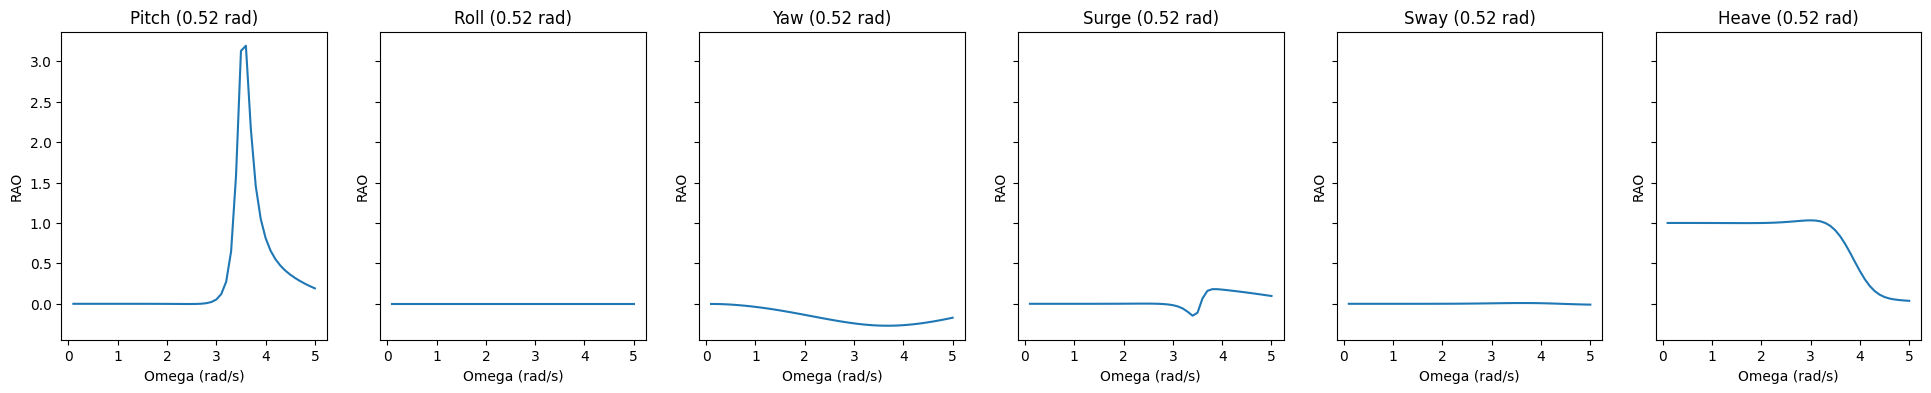

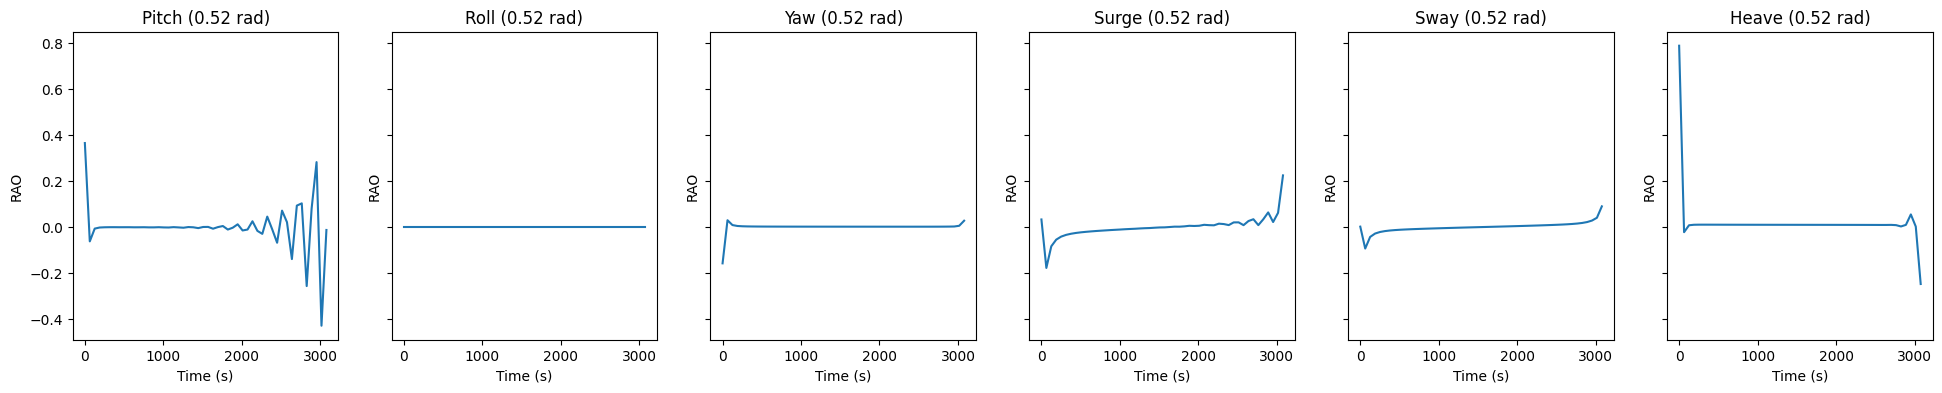

In [107]:
# wave_dirs = [0, np.pi/12, np.pi/6, np.pi/2, np.pi]
wave_dir = np.pi/6
plot_rao_freq(
    [ "Pitch", "Roll", "Yaw", "Surge", "Sway", "Heave"],
    wave_dir=wave_dir,
    tol=1e-3
)
plot_rao_time(
    [ "Pitch","Roll", "Yaw", "Surge", "Sway", "Heave"],
    wave_dir=wave_dir,
    tol=1e-3
)